## Data preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
)
from utopian_distance import distance_from_utopia_negative
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import utils
import json


from tuned_tabpfn_custom import TunedTabPFNClassifier
#from tabpfn_extensions.hpo import TunedTabPFNClassifier
from tabpfn_extensions import interpretability
from tabpfn import TabPFNClassifier

In [3]:
# Open and read the JSON file with data splits
with open('apollo_split.json', 'r') as file:
    data_split = json.load(file)

# Print the data
print(data_split)

{'TRAIN_SET': ['CAMPUS_248', '175-857', 'CAMPUS_285', '175-222', '175-720', 'HUMANITAS_34', '175-472', '175-995', '175-696', '175-258', 'CAMPUS_288', '175-713', '175-742', '175-601', '175-846', '175-398', '175-149', '175-639', '175-505', '175-692', '175-733', '175-279', 'CAMPUS_86', 'CAMPUS_93', '175-630', '175-234', '175-548', '175-656', 'CAMPUS_271', '175-158', '175-619', '175-659', '175-289', '175-611', '175-738', '175-402', '175-109', 'CAMPUS_174-227', '175-967', 'NOVARA_22', '175-691', 'CAMPUS_174-3', '175-861', '175-686', '175-385', '175-939', '175-6', '175-87', 'CAMPUS_108', '175-407', 'FEDERICO_16', '175-677', '175-451', '175-395', '175-93', 'CAMPUS_139', '175-490', '175-450', '175-633', '175-671', '175-946', 'HUMANITAS_24', '175-802', '175-864', '175-568', 'FEDERICO_4', 'CAMPUS_174-205', '175-935', '175-953', '175-119', '175-940', '175-550', 'CAMPUS_293', '175-942', 'HUMANITAS_26', 'CAMPUS_135', '175-977', '175-701', 'CAMPUS_79', '175-856', 'SACCO_S017', 'CAMPUS_279', '175-19'

In [4]:
# Create train, test and validation sets
train = df[df['Subject'].isin(data_split['TRAIN_SET'])]
test = df[df['Subject'].isin(data_split['TEST_SET'])]
val = df[df['CENTER'] == 'Niguarda']

In [5]:
def convert_to_float(x):
    """Convert comma separated number from string to float"""
    try:
        return float(str(x).replace(',', '.'))
    except:
        return None

In [6]:
def prepare_set(set, drop_features, cens_features, target, str_to_float_features):
    """ 
    Prepare the dataset
        set: dataset to transform
        drop_features: list of features to drop
        cens_features: list of 2 features, censor if both features are equal to 0
        target: string, target feature
        str_to_float_features: list of str features with "," instead of "." that have to be converted into floats
    """

    # Drop censored patients
    index_cens = set[(set[cens_features[0]] == 0) & (set[cens_features[1]] == 0)].index
    set_cens = set.drop(index_cens)

    # Drop irrelevant features
    set_dropped = set_cens.drop(drop_features, axis = 1)

    # Drop rows that don't have a target feature
    set_cens_dropped = set_dropped.dropna(subset=target, axis=0)

    # Convert str features to floats
    set_cens_float = set_cens_dropped
    for col in str_to_float_features:
        set_cens_float[col] = set_cens_dropped[col].apply(lambda x: convert_to_float(x))

    # Split into features and targets
    X = set_cens_float.drop(target, axis = 1)
    y = set_cens_float.loc[:, target]

    return X, y

In [7]:
drop_features = ['Subject','i3lung_id', 'CENTER', 'TREATMENT_START', 'TREATMENT_END', 'PROGRESSION_DATE', 'DEATH_DATE',
                'BEST_RESPONSE', 'TREATMENT_ONGOING', 'PROGRESSION', 'DCR', 'CBR', 'ORR', 'OS_MONTHS', 'DEATH_EVENT_OC', 'PFS_MONTHS', 
                'PROGRESSION_EVENT_OC', 'TTF_MONTHS', 'THERAPY_END_EVENT_OC', 'OS_THRESHOLD_24']
cens_features = ['OS_THRESHOLD_6', 'DEATH_EVENT_OC']
target = 'OS_THRESHOLD_6'
str_to_float_features = ['LINE_NUM','AGE_AT_DIAGNOSIS', 'AGE_AT_IO_START', 'SMOKING_PACKSYEAR', 'BMI_BASAL',
                     'LAB22_LDH_BASAL', 'LAB16_NEUTROPHYL_BASAL', 'LAB17_MONOCYTE_BASAL', 'LAB19_LYMPHOCYTES_BASAL', 'NLR', 'CF02_WEIGHT_BASAL']

X_test, y_test = prepare_set(test, drop_features, cens_features, target, str_to_float_features)
X_train, y_train = prepare_set(train, drop_features, cens_features, target, str_to_float_features)
X_val, y_val = prepare_set(val, drop_features, cens_features, target, str_to_float_features)

C:\Users\olgak\AppData\Local\Temp\ipykernel_17416\1772823154.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_cens_float[col] = set_cens_dropped[col].apply(lambda x: convert_to_float(x))


## Default model

In [8]:
model = TabPFNClassifier()
model.fit(X_train, y_train)

TabPFNClassifier()

In [12]:
prediction_probabilities = model.predict_proba(X_test)
predictions = np.argmax(prediction_probabilities, axis=1)

print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

ROC AUC: 0.8174603174603174


In [13]:
f1_macro = f1_score(y_test, predictions, average='macro')
print("F-macro", f1_macro)

F-macro 0.6376173708920188


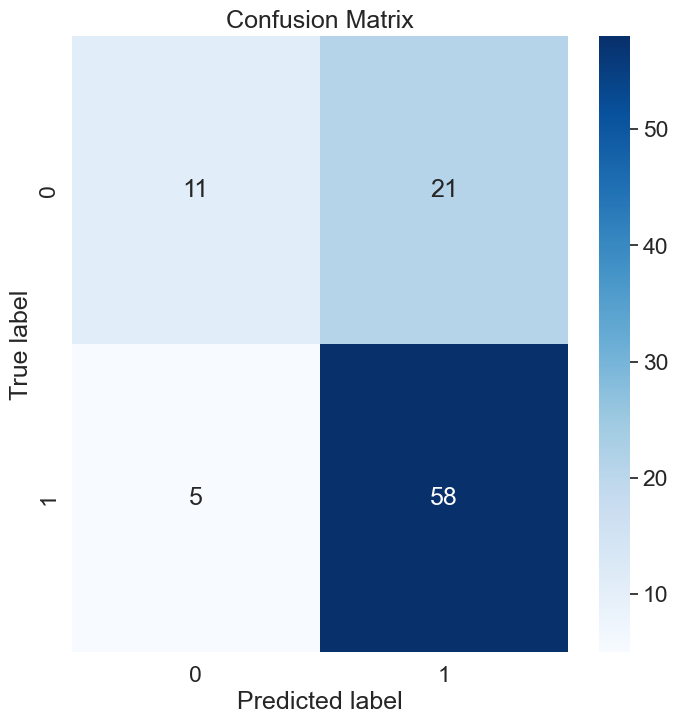

In [14]:
cm = confusion_matrix(y_test, predictions)

sns.set(font_scale=1.5)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## PHE

In [15]:
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier

In [17]:
clf = AutoTabPFNClassifier(max_time=60 * 3)
clf.fit(X_train, y_train)

c:\Users\olgak\AppData\Local\Programs\Python\Python311\Lib\site-packages\tabpfn\classifier.py:431: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(self.device, X)
c:\Users\olgak\AppData\Local\Programs\Python\Python311\Lib\site-packages\tabpfn\classifier.py:431: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(self.device, X)
c:\Users\olgak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\olgak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in colu

AutoTabPFNClassifier(categorical_feature_indices=[0, 3, 4, 5, 6, 7, 8, 10, 11,
                                                  12, 13, 14, 15, 16, 17, 18,
                                                  19, 20, 21, 22, 23, 24, 25,
                                                  26, 27, 28, 29, 30, 31, 32, ...],
                     max_time=180)

In [18]:
prediction_probabilities = clf.predict_proba(X_test)
predictions = np.argmax(prediction_probabilities, axis=-1)
print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

ROC AUC: 0.7420634920634921


In [19]:
f1_macro = f1_score(y_test, predictions, average='macro')
print("F-macro", f1_macro)

F-macro 0.4571428571428572


## Tune hyperparameters

In [ ]:
clf_tuned = TunedTabPFNClassifier(n_trials=50, metric="roc_auc")
clf_tuned.fit(X_train, y_train)

In [ ]:
best_model = clf_tuned.best_model_
best_model

In [ ]:
config = {'inference_config' : best_model.inference_config}
with open('config_auc_os6.json', 'w') as f:
    json.dump(config, f)

## Load best hyperparameters

In [20]:
with open('config_auc_os6.json', 'r') as f:
    config = json.load(f)

## Cost search

In [22]:
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

In [23]:
class Point:
    """
    Class to represent a point in a plot.

    :param x: x-coordinate of the point.
    :param y: y-coordinate of the point.
    :param color: Color of the point.
    :param attributes: Attributes of the point.
    """
    color = ''
    attributes = {}

    def __init__(self, x: float, y: float, color: str = "#979EFF", size: int = 6, attributes: dict = {}):
        self.x = x
        self.y = y
        self.color = color
        self.size = size
        self.attributes = attributes


class Line:
    """
    Class to represent a line in a plot.

    :param x_values: x-coordinates of the line.
    :param y_values: y-coordinates of the line.
    :param color: Color of the line.
    :param attributes: Attributes of the line.
    """
    color = ''
    attributes = {}

    def __init__(self, x_values: list[float], y_values: list[float], color: str = "#979EFF", attributes: dict = {}):
        self.x_values = x_values
        self.y_values = y_values
        self.color = color
        self.attributes = attributes

def plot_cost_search(data: dict) -> go.Figure:
    """
    Plot the cost search graph.

    :param data: Data to be plotted. It should have
        - points: Dictionary of points to be plotted. Keys are point names and values are Point objects.
        - lines: Dictionary of lines to be plotted. Keys are line names and values are Line objects.
        - graph_title: Title of the graph.
        - x_axis_name: Name of the x-axis.
        - y_axis_name: Name of the y-axis.

    :return: Plotly figure.
    """
    points: dict[str: Point] = data['points']
    lines: dict[str: Line] = data['lines']

    fig = go.Figure()

    for line_name, line_data in lines.items():
        fig.add_trace(go.Scatter(
            x=line_data.x_values,
            y=line_data.y_values,
            mode='lines',
            marker=dict(color=line_data.color),
            name=line_name,
            showlegend=False
        ))
    
    for point_name, point_data in points.items():
        hover_text = [
            '<br>'.join(f'{key}: {value}' for key, value in zip(point_data.attributes.keys(), values))
            for values in zip(*point_data.attributes.values())
        ]

        fig.add_trace(go.Scatter(
            x=[point_data.x],
            y=[point_data.y],
            mode='markers',
            marker=dict(size=point_data.size, color=point_data.color),
            text=hover_text,
            name=point_name,
            showlegend=False)
        )

    fig.update_layout(title=data['graph_title'],
                    xaxis_title=data['x_axis_name'],
                    yaxis_title=data['y_axis_name'])

    return fig

In [ ]:
def distance_from_utopia_negative(y_true, y_pred):
    """
    Get distance from the utopian point
    - y_true: array of true labels
    - y_pred: array of predicted labels
    """
    utopian_point = [0, (np.sum(y_true == 0) / len(y_true))]

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    x = fn / (tn + fn + tp + fp)
    y = (tn + fn) / (tn + fn + tp + fp)

    distance = np.sqrt((x - utopian_point[0]) ** 2 + (y - utopian_point[1]) ** 2)

    return distance


def predict_with_threshold(prediction_probabilities, threshold):
    """
    Get predictions from probabilities over classes with cut-off of choice.
    - prediction_probabilities: array of shape [n, 2] with probabilities for 2 classes
    - threshold: cut-off for class 0. Takes values between 0 and 1

    Returns of array of predictions 
    """

    predictions = np.empty(len(prediction_probabilities))
    for i in range(len(prediction_probabilities)):
        if prediction_probabilities[i][0] >= threshold:
            predictions[i] = 0
        else:
            predictions[i] = 1
    return predictions


# Pass predictions already with threshold
def get_point_attributes(predictions, prediction_probabilities, labels, threshold, cm, x, y):
    """
    Get attributes for the point un cost search plot to display in hover_text
    - predictions: array of 0 and 1 predictions
    - labels: true labels
    - threshold: cut-off for class 0. Takes values between 0 and 1
    - cm: confusion matrix for predictions
    - x: false negative percentage
    - y: overall negative predicted percentage

    Returns dict of attributes
    """
    attributes = {'Threshold': [round(threshold, 3)],
                  'False negative percentage': [round(x, 2)], 
                  'Negative predicted percentage': [round(y, 2)],
                  'Distance from utopia': [round(distance_from_utopia_negative(labels, predictions), 4)],
                  'Sensitivity': [round(cm[0,0]/(cm[0,0]+cm[0,1]), 4)],
                  'Specificity': [round(cm[1,1]/(cm[1,0]+cm[1,1]), 4)],
                  'F1-macro': [round(f1_score(labels, predictions, average='macro'), 4)],
                  'ROC AUC': [round(roc_auc_score(labels, prediction_probabilities[:, 1]), 4)]
                  }
    return attributes


def get_points(prediction_probabilities, labels, step):
    """
    Get points and lines for the search cost plot.
    - prediction_probabilities: array of shape [n, 2] with probabilities for 2 classes
    - labels: true labels
    - step: step for threshold increase

    Returns dict of Points and dict of Lines.
    """
    points = {}
    lines = {}
    prev_point = [0,0]
    best_point = None
    min_distance = 1
    threshold_for_min_distance = 0
    threshold = 0

    # Create utopian point
    utopian_point = Point(0, (np.sum(labels == 0) / labels.size), color='red')
    points['utopian'] = utopian_point

    while threshold<=1:
        predictions = predict_with_threshold(prediction_probabilities, threshold)
        cm = confusion_matrix(labels, predictions)
        x = cm[1,0]/len(predictions)
        y = (cm[0,0] + cm[1,0])/len(predictions)
        point = Point(x,y, attributes=get_point_attributes(predictions, prediction_probabilities, labels, threshold, cm, x, y))
        points[str(threshold)] = point

        if threshold > 0:
            line = Line([prev_point[0], x], [prev_point[1], y])
            lines[str(threshold)] = line
        
        if distance_from_utopia_negative(labels, predictions) < min_distance:
            min_distance = distance_from_utopia_negative(labels, predictions)
            threshold_for_min_distance = threshold
            best_model = str(threshold)

        prev_point = [x, y]
        threshold += step
    
    # Make the best model visualy distinguishable
    points[best_model].color = "#0DC700"
    points[best_model].size = 10
    return points, lines, threshold_for_min_distance

In [25]:
X_train_cost, X_val_cost, y_train_cost, y_val_cost = train_test_split(
                X_train,
                y_train,
                test_size=0.2,
                random_state=42,
            )

model_cost = TabPFNClassifier(inference_config = config['inference_config'])
model_cost.fit(X_train_cost, y_train_cost)


TabPFNClassifier(inference_config={'FINGERPRINT_FEATURE': True,
                                   'OUTLIER_REMOVAL_STD': 9.0,
                                   'POLYNOMIAL_FEATURES': 'no',
                                   'PREPROCESS_TRANSFORMS': [{'append_original': False,
                                                              'categorical_name': 'none',
                                                              'global_transformer_name': 'svd',
                                                              'name': 'quantile_uni',
                                                              'subsample_features': -1}],
                                   'SUBSAMPLE_SAMPLES': None})

In [26]:
prediction_probabilities = model_cost.predict_proba(X_val_cost)

In [27]:
points, lines, best_threshold = get_points(prediction_probabilities, y_val_cost, 0.025)
data = {'points': points, 'lines': lines,
        'graph_title': 'Cost search', 'x_axis_name': 'False negative percentage', 'y_axis_name': 'Negative predictions percentage'}
print(best_threshold)
fig = plot_cost_search(data)
fig.show()

0.4250000000000001


In [19]:
fig.write_image("cost_search_os6.png")

## Performance on the test set

In [28]:
model = TabPFNClassifier(inference_config = config['inference_config'])
model.fit(X_train, y_train)

TabPFNClassifier(inference_config={'FINGERPRINT_FEATURE': True,
                                   'OUTLIER_REMOVAL_STD': 9.0,
                                   'POLYNOMIAL_FEATURES': 'no',
                                   'PREPROCESS_TRANSFORMS': [{'append_original': False,
                                                              'categorical_name': 'none',
                                                              'global_transformer_name': 'svd',
                                                              'name': 'quantile_uni',
                                                              'subsample_features': -1}],
                                   'SUBSAMPLE_SAMPLES': None})

In [31]:
prediction_probabilities = model.predict_proba(X_test)
predictions = predict_with_threshold(prediction_probabilities, best_threshold)

print("ROC AUC:", roc_auc_score(y_test, prediction_probabilities[:, 1]))

ROC AUC: 0.8338293650793651


In [32]:
f1_macro = f1_score(y_test, predictions, average='macro')
print("F-macro", f1_macro)

F-macro 0.766463966877992


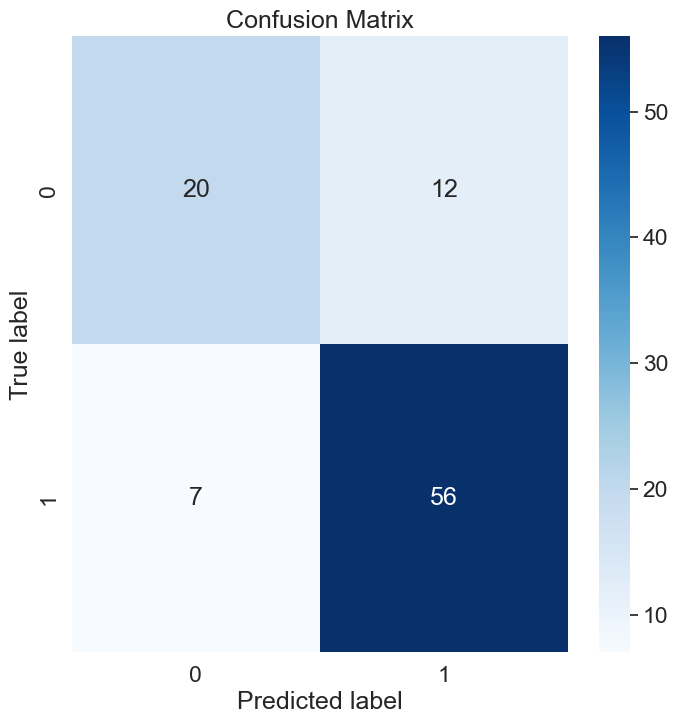

In [33]:
cm = confusion_matrix(y_test, predictions)

sns.set(font_scale=1.5)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [34]:
sensitivity = [round(cm[0,0]/(cm[0,0]+cm[0,1]), 4)]
specificity = [round(cm[1,1]/(cm[1,0]+cm[1,1]), 4)]
sensitivity, specificity

([0.625], [0.8889])

## External validation

In [35]:
prediction_probabilities = model.predict_proba(X_val)
predictions = predict_with_threshold(prediction_probabilities, best_threshold)

print("ROC AUC:", roc_auc_score(y_val, prediction_probabilities[:, 1]))

ROC AUC: 0.7602040816326532


In [36]:
f1_macro = f1_score(y_val, predictions, average='macro')
print("F-macro", f1_macro)

F-macro 0.6154987022617724


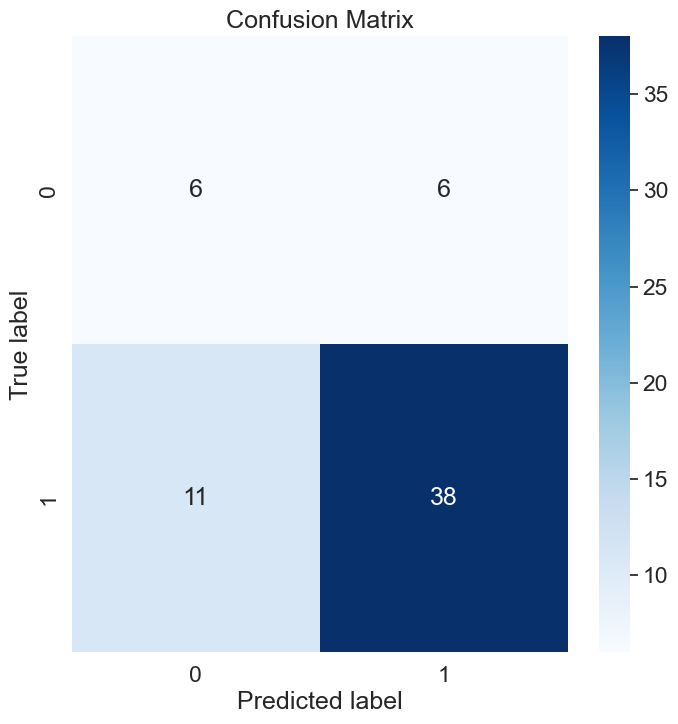

In [37]:
cm = confusion_matrix(y_val, predictions)
sns.set(font_scale=1.5)

sns.set(font_scale=1.5)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [38]:
sensitivity = [round(cm[0,0]/(cm[0,0]+cm[0,1]), 4)]
specificity = [round(cm[1,1]/(cm[1,0]+cm[1,1]), 4)]
sensitivity, specificity

([0.5], [0.7755])

## Interpretability
Only run with GPU!

In [ ]:
import shap

In [ ]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

In [ ]:
exp_model = TabPFNClassifier(inference_config = config['inference_config'])
exp_model.fit(X_train_np, y_train_np)

In [71]:
# Get feature names for SHAP to explain
feature_names = utils.validation._get_feature_names(X_train)
feature_names

array(['LINE_NUM', 'AGE_AT_DIAGNOSIS', 'AGE_AT_IO_START', 'GENDER_M',
       'CF03_ECOG_BASAL', 'C94_SMOKING_CURRENT', 'C94_SMOKING_FORMER',
       'C94_SMOKING_NEVER', 'EVER_SMOKED', 'SMOKING_PACKSYEAR',
       'SMOKING_PACKYEAR_CUTOFF_10', 'NSCLC_HISTOLOGY_SQUAMOUS',
       'PDL1_CATHEGORY', 'B07_STAGE_DIAGNOSIS_T', 'B08_STAGE_DIAGNOSIS_N',
       'B09_STAGE_DIAGNOSIS_M', 'DIAG_STAGE', 'T_IO_START', 'N_IO_START',
       'M_IO_START', 'STAGE_IO_START', 'SITE_METS_IO_START_LUNG',
       'SITE_METS_IO_START_LYMPH NODES', 'SITE_METS_IO_START_LIVER',
       'SITE_METS_IO_START_ADRENAL',
       'SITE_METS_IO_START_PARENCHYMAL BRAIN',
       'SITE_METS_IO_START_LEPTOMENINGEAL', 'SITE_METS_IO_START_BONE',
       'SITE_METS_IO_START_SOFT TISSUE', 'SITE_METS_IO_START_SKIN',
       'SITE_METS_IO_START_PLEURA', 'SITE_METS_IO_START_PLEURAL EFFUSION',
       'SITE_METS_IO_START_PERICARDIAL EFFUSION',
       'SITE_METS_IO_START_BONE MARROW', 'SITE_METS_IO_START_OTHER',
       'D35_SURGERY_1', 'LAB2

In [ ]:
def predict_fn(X):
    return exp_model.predict_proba(X)[:, 1]

In [ ]:
background = X_train_np[np.random.choice(X_train_np.shape[0], 100, replace=False)]

In [ ]:
explainer = shap.Explainer(predict_fn, background, feature_names=feature_names)

In [ ]:
# Compute SHAP values for 50 samples
shap_values = explainer(X_test[:50])

In [ ]:
shap.plots.beeswarm(shap_values)